# Unified Synthesis: KW-PE Expressiveness vs Downstream Failure Gap Analysis

This notebook demonstrates the unified synthesis evaluation that combines results from **4 experiments**:

1. **Ablation Decomposition** — Topology attribution, nonlinearity margins, EDMD effects on 525 graph pairs
2. **Downstream Failure Anatomy** — EDMD conditioning analysis and ZINC-12k training dynamics
3. **Theoretical Positioning** — PE method taxonomy, nRWPE vs RWPE failure overlap (Venn analysis)
4. **Benchmark Saturation & PE Quality** — Utility scores, expressiveness-downstream correlation

**Key findings**: Walk topology is necessary and sufficient for 100% discrimination; EDMD conditioning is catastrophic (~10^20 condition numbers); nRWPE is the most practically useful PE method.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# No non-Colab packages needed beyond core scientific stack

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scipy==1.16.3', 'matplotlib==3.10.0')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aii-pipeline 0.1.0 requires pandas>=2.3.0, but you have pandas 2.2.2 which is incompatible.
owid-catalog 0.4.5 requires pandas>=2.2.3, but you have pandas 2.2.2 which is incompatible.
owid-datautils 0.6.2 requires pandas>=2.2.3, but you have pandas 2.2.2 which is incompatible.
owid-repack 0.1.7 requires pandas>=2.2.3, but you have pandas 2.2.2 which is incompatible.
tooluniverse 1.0.20 requires numpy>=2.2.0, but you have numpy 2.0.2 which is incompatible.
tooluniverse 1.0.20 requires pandas>=2.2.3, but you have pandas 2.2.2 which is incompatible.


In [2]:
import json
import math
import re
from collections import defaultdict
from typing import Any

import numpy as np
from scipy import stats as scipy_stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

## Data Loading

Load the pre-computed evaluation output (47 curated graph pairs across 10 benchmark categories).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/evaluation_iter3_unified_synthes/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded evaluation data: {len(data['metrics_agg'])} aggregate metrics, "
      f"{len(data['datasets'][0]['examples'])} example pairs")

Loaded evaluation data: 36 aggregate metrics, 47 example pairs


## Configuration

Tunable parameters for the analysis. The discrimination threshold determines when a pair is considered "distinguished".

In [5]:
# --- Config ---
# Discrimination threshold: distance > threshold => pair is distinguished
DISCRIMINATION_THRESHOLD = 1e-5

# Maximum number of examples to process (None = all)
# Original: None (all 525 pairs in the full dataset)
MAX_EXAMPLES = None

# Ablation method groupings
LINEAR_METHODS = ["A1_linear_walk_full_EDMD", "A3_linear_walk_raw_traj"]
NONLINEAR_METHODS = ["A4_nonlinear_walk_DMD_deg1", "A5_nonlinear_walk_diag_EDMD", "A6_nonlinear_walk_full_EDMD"]
EDMD_METHODS = ["A1_linear_walk_full_EDMD", "A5_nonlinear_walk_diag_EDMD", "A6_nonlinear_walk_full_EDMD"]
RAW_METHODS = ["A3_linear_walk_raw_traj"]
RANDOM_METHOD = "A2_random_feat_full_EDMD"

# PE methods for utility comparison
PE_METHODS = ["RWPE", "LapPE", "nRWPE_tanh", "KW_PE_tanh"]

## Analysis 1: Ablation Decomposition

Extract per-pair distances from examples and compute:
- **Topology attribution**: walk-based methods vs random control
- **Nonlinearity margin boost**: nonlinear vs linear methods per category
- **EDMD margin effect**: EDMD-processed vs raw trajectory per category

In [6]:
# Extract per-pair distances from examples
examples = data['datasets'][0]['examples']
if MAX_EXAMPLES is not None:
    examples = examples[:MAX_EXAMPLES]

# Build per-pair distance dict: method -> category -> list of distances
method_distances = defaultdict(lambda: defaultdict(list))
method_all_distances = defaultdict(list)

for ex in examples:
    category = ex.get("metadata_category", "unknown")
    for key, val in ex.items():
        if key.startswith("predict_") and not key.startswith("predict_main_"):
            method_name = key.replace("predict_", "")
            try:
                pred = json.loads(val)
                dist = float(pred.get("distance", 0.0))
                method_distances[method_name][category].append(dist)
                method_all_distances[method_name].append(dist)
            except (json.JSONDecodeError, TypeError, ValueError):
                pass

all_methods = list(method_all_distances.keys())
categories = sorted(set(ex.get("metadata_category", "unknown") for ex in examples))

print(f"Processed {len(examples)} examples across {len(categories)} categories")
print(f"Methods found: {all_methods}")

# Topology attribution: walk methods vs random control
random_dists = method_all_distances.get(RANDOM_METHOD, [])
random_rate = np.mean([d > DISCRIMINATION_THRESHOLD for d in random_dists]) if random_dists else 0.0

walk_methods = [m for m in all_methods if m != RANDOM_METHOD]
walk_rates = []
for m in walk_methods:
    dists = method_all_distances[m]
    rate = np.mean([d > DISCRIMINATION_THRESHOLD for d in dists])
    walk_rates.append(rate)

avg_walk_rate = np.mean(walk_rates) if walk_rates else 0.0
topology_attribution = avg_walk_rate - random_rate

print(f"\nTopology Attribution: {topology_attribution:.4f}")
print(f"  Walk methods avg rate: {avg_walk_rate:.4f}")
print(f"  Random control rate: {random_rate:.4f}")

Processed 47 examples across 10 categories
Methods found: ['A1_linear_walk_full_EDMD', 'A2_random_feat_full_EDMD', 'A3_linear_walk_raw_traj', 'A4_nonlinear_walk_DMD_deg1', 'A5_nonlinear_walk_diag_EDMD', 'A6_nonlinear_walk_full_EDMD', 'RWPE', 'LapPE', 'nRWPE_tanh', 'KW_PE_softplus']

Topology Attribution: 0.9527
  Walk methods avg rate: 0.9527
  Random control rate: 0.0000


In [7]:
# Nonlinearity margin boost: nonlinear vs linear methods per category
nonlinearity_margin_boost = {}
for cat in categories:
    lin_dists = []
    for m in LINEAR_METHODS:
        lin_dists.extend(method_distances.get(m, {}).get(cat, []))
    nonlin_dists = []
    for m in NONLINEAR_METHODS:
        nonlin_dists.extend(method_distances.get(m, {}).get(cat, []))
    lin_mean = np.mean(lin_dists) if lin_dists else 0.0
    nonlin_mean = np.mean(nonlin_dists) if nonlin_dists else 0.0
    if lin_mean > 1e-10:
        nonlinearity_margin_boost[cat] = float(nonlin_mean / lin_mean)
    else:
        nonlinearity_margin_boost[cat] = float('inf') if nonlin_mean > 0 else 1.0

# EDMD margin effect: EDMD-processed vs raw trajectory per category
edmd_margin_effect = {}
for cat in categories:
    edmd_dists = []
    for m in EDMD_METHODS:
        edmd_dists.extend(method_distances.get(m, {}).get(cat, []))
    raw_dists = []
    for m in RAW_METHODS:
        raw_dists.extend(method_distances.get(m, {}).get(cat, []))
    edmd_mean = np.mean(edmd_dists) if edmd_dists else 0.0
    raw_mean = np.mean(raw_dists) if raw_dists else 0.0
    if raw_mean > 1e-10:
        edmd_margin_effect[cat] = float(edmd_mean / raw_mean)
    else:
        edmd_margin_effect[cat] = float('inf') if edmd_mean > 0 else 1.0

print("Nonlinearity Margin Boost (per category):")
for cat, boost in sorted(nonlinearity_margin_boost.items()):
    print(f"  {cat}: {boost:.4f}")

print("\nEDMD Margin Effect (per category):")
for cat, effect in sorted(edmd_margin_effect.items()):
    print(f"  {cat}: {effect:.4f}")

Nonlinearity Margin Boost (per category):
  BREC_4Vertex: 1.0227
  BREC_Basic: 1.0193
  BREC_CFI: 0.8926
  BREC_Distance_Regular: 0.9857
  BREC_Extension: 0.9923
  BREC_Regular: 1.0109
  BREC_Strongly_Regular: 0.9994
  CSL: 1.0351
  cospectral: 1.0416
  strongly_regular: 1.0877

EDMD Margin Effect (per category):
  BREC_4Vertex: 0.9133
  BREC_Basic: 1.0106
  BREC_CFI: 0.9032
  BREC_Distance_Regular: 0.9992
  BREC_Extension: 0.9882
  BREC_Regular: 1.0408
  BREC_Strongly_Regular: 1.0140
  CSL: 1.0635
  cospectral: 1.1578
  strongly_regular: 1.0883


## Analysis 2: Downstream Failure Anatomy

Examine EDMD conditioning (catastrophic condition numbers) and ZINC-12k training dynamics showing why high expressiveness doesn't translate to good downstream performance.

In [8]:
# EDMD conditioning from pre-computed analysis
a2 = data['metadata']['analysis_2_downstream_failure']
edmd_cond = a2['edmd_conditioning']

print("=== EDMD Conditioning Analysis ===")
print(f"Degree-2 median condition number: {edmd_cond['deg2_median_condition_number']:.2e}")
print(f"Degree-2 mean condition number:   {edmd_cond['deg2_mean_condition_number']:.2e}")
print(f"Degree-2 max condition number:    {edmd_cond['deg2_max_condition_number']:.2e}")
print(f"Effective precision lost:         {edmd_cond['deg2_effective_precision_lost']:.1f} digits (double precision limit: 16)")
print(f"Degree-1 median condition number: {edmd_cond['deg1_median_condition_number']:.2f} (well-conditioned)")

# Training dynamics from ZINC-12k
print("\n=== ZINC-12k Training Dynamics ===")
training = a2['training_dynamics']
print(f"{'Method':<25} {'Test MAE':>10} {'Best Val MAE':>12} {'Best Epoch':>10} {'Gen. Gap':>10}")
print("-" * 70)
for name, dyn in training.items():
    print(f"{name:<25} {dyn['test_mae']:>10.4f} {dyn['best_val_mae']:>12.4f} {dyn['best_epoch']:>10d} {dyn['generalization_gap']:>10.4f}")

# Failure mode attribution
print("\n=== Failure Mode Attribution ===")
for mode, info in a2['failure_mode_attribution'].items():
    print(f"  [{info['severity'].upper()}] {mode}: {info['detail']}")

=== EDMD Conditioning Analysis ===
Degree-2 median condition number: 4.07e+20
Degree-2 mean condition number:   1.57e+36
Degree-2 max condition number:    4.83e+37
Effective precision lost:         20.6 digits (double precision limit: 16)
Degree-1 median condition number: 29.25 (well-conditioned)

=== ZINC-12k Training Dynamics ===
Method                      Test MAE Best Val MAE Best Epoch   Gen. Gap
----------------------------------------------------------------------
GIN_(no_PE)                   0.2849       0.2902        228    -0.0053
GIN_plus_RWPE                 0.1845       0.2034        293    -0.0189
GIN_plus_LapPE                0.2394       0.2846        186    -0.0452
GIN_plus_KW-PE                0.3354       0.3538        166    -0.0184

=== Failure Mode Attribution ===
  [CRITICAL] conditioning: Median condition number ~10^21 exceeds double precision limit (~10^16), destroying all numerical information
  [MODERATE] scale_mismatch: EDMD-processed PEs may have extreme 

## Analysis 3: Theoretical Positioning

PE method taxonomy and the nRWPE vs RWPE failure overlap analysis (Venn diagram), showing that nRWPE breaks spectral invariance while maintaining equivariance.

In [9]:
# PE Method Taxonomy from pre-computed analysis
a3 = data['metadata']['analysis_3_theoretical_positioning']
taxonomy = a3['taxonomy_table']

print("=== PE Method Taxonomy ===")
print(f"{'Method':<15} {'Spectral Inv.':>13} {'Equivariant':>11} {'Eigen-Free':>10} {'Discrim. Rate':>13}")
print("-" * 65)
for method, info in taxonomy.items():
    si = "Yes" if info['spectral_invariant'] else "No"
    eq = "Yes" if info['equivariant'] else "No"
    ef = "Yes" if info['eigendecomp_free'] else "No"
    print(f"{method:<15} {si:>13} {eq:>11} {ef:>10} {info['discrimination_rate']:>13.4f}")

# Venn overlap: nRWPE vs RWPE failures
overlap = a3['nrwpe_vs_rwpe_failure_overlap']
print(f"\n=== nRWPE vs RWPE Failure Overlap (Venn) ===")
print(f"  Both succeed:     {overlap['both_succeed']:>4d} pairs")
print(f"  Only RWPE fails:  {overlap['only_rwpe_fails']:>4d} pairs (nRWPE distinguishes but RWPE cannot)")
print(f"  Only nRWPE fails: {overlap['only_nrwpe_fails']:>4d} pairs")
print(f"  Both fail:        {overlap['both_fail']:>4d} pairs")
print(f"  Total:            {overlap['total_pairs']:>4d} pairs")

# Spectral invariance breaking evidence
print(f"\n=== Spectral Invariance Breaking Evidence ===")
for cat in ["cospectral", "CSL"]:
    si = a3['spectral_invariance_breaking_evidence'].get(cat, {})
    if si:
        print(f"  {cat}: nRWPE={si['nrwpe_rate']:.4f}, RWPE={si['rwpe_rate']:.4f} "
              f"({si['nrwpe_distinguished']}/{si['total']} vs {si['rwpe_distinguished']}/{si['total']})")

=== PE Method Taxonomy ===
Method          Spectral Inv. Equivariant Eigen-Free Discrim. Rate
-----------------------------------------------------------------
RWPE                      Yes         Yes        Yes        0.6876
LapPE                      No          No         No        0.9981
nRWPE_tanh                 No         Yes        Yes        0.8171
KW_PE_tanh                 No          No         No        1.0000

=== nRWPE vs RWPE Failure Overlap (Venn) ===
  Both succeed:      357 pairs
  Only RWPE fails:    72 pairs (nRWPE distinguishes but RWPE cannot)
  Only nRWPE fails:    4 pairs
  Both fail:          92 pairs
  Total:             525 pairs

=== Spectral Invariance Breaking Evidence ===
  cospectral: nRWPE=1.0000, RWPE=0.9844 (64/64 vs 63/64)
  CSL: nRWPE=1.0000, RWPE=0.0000 (59/59 vs 0/59)


## Analysis 4: Benchmark Saturation & PE Quality

Compute PE utility scores (combining expressiveness, conditioning, cost, and downstream MAE) and the expressiveness-downstream correlation.

In [10]:
# PE Utility Scores from pre-computed analysis
a4 = data['metadata']['analysis_4_benchmark_saturation']
pe_utility = a4['pe_utility_scores']

print("=== PE Utility Scores ===")
print(f"{'Method':<15} {'Utility':>8} {'Expr Rate':>10} {'Cond Factor':>11} {'Cost Factor':>11} {'MAE Factor':>10}")
print("-" * 68)
for method in PE_METHODS:
    info = pe_utility.get(method, {})
    if info:
        print(f"{method:<15} {info['utility_score']:>8.3f} {info['expressiveness_rate']:>10.4f} "
              f"{info['conditioning_factor']:>11.4f} {info['cost_factor']:>11.4f} {info['mae_factor']:>10.3f}")

# Expressiveness-downstream correlation
corr = a4['expressiveness_downstream_correlation']
print(f"\n=== Expressiveness vs Downstream MAE Correlation ===")
print(f"  Spearman rho: {corr['spearman_rho']:.4f} (p={corr['spearman_p_value']:.4f})")
print(f"  Interpretation: {corr['interpretation']}")
print(f"\n  Methods:            {corr['methods_used']}")
print(f"  Expressiveness:     {corr['expressiveness_rates']}")
print(f"  Downstream MAEs:    {corr['downstream_maes']}")

# Benchmark difficulty
print(f"\n=== Benchmark Difficulty Scores ===")
for cat, info in sorted(a4['benchmark_difficulty'].items()):
    print(f"  {cat:<25} difficulty={info['difficulty_score']:.2f} ({info['methods_at_100_pct']}/{info['total_methods']} at 100%)")

=== PE Utility Scores ===
Method           Utility  Expr Rate Cond Factor Cost Factor MAE Factor
--------------------------------------------------------------------
RWPE               3.683     0.6876      1.0000      0.9881      5.420
LapPE              4.120     0.9981      1.0000      0.9881      4.177
nRWPE_tanh         4.579     0.8171      1.0000      0.9823      5.705
KW_PE_tanh         0.944     1.0000      0.4370      0.7241      2.982

=== Expressiveness vs Downstream MAE Correlation ===
  Spearman rho: 0.4000 (p=0.6000)
  Interpretation: Weak/negative correlation suggests higher expressiveness does NOT guarantee better downstream performance

  Methods:            ['RWPE', 'LapPE', 'KW_PE_tanh', 'no_PE']
  Expressiveness:     [0.6876, 0.9981, 1.0, 0.0]
  Downstream MAEs:    [0.1845, 0.2394, 0.3354, 0.2849]

=== Benchmark Difficulty Scores ===
  BREC_4Vertex              difficulty=0.12 (7/8 at 100%)
  BREC_Basic                difficulty=0.12 (7/8 at 100%)
  BREC_CFI       

## Aggregate Metrics Summary

All 36 aggregate metrics from the unified synthesis evaluation.

In [11]:
# Display all aggregate metrics
metrics = data['metrics_agg']
print(f"=== All {len(metrics)} Aggregate Metrics ===\n")
for k, v in metrics.items():
    if isinstance(v, float):
        if abs(v) > 1e6 or (abs(v) < 1e-3 and v != 0):
            print(f"  {k:<45} {v:.4e}")
        else:
            print(f"  {k:<45} {v:.4f}")
    else:
        print(f"  {k:<45} {v}")

=== All 36 Aggregate Metrics ===

  topology_attribution                          1.0000
  walk_avg_rate                                 1.0000
  random_control_rate                           0.0000
  nonlinearity_margin_boost_mean                1.0011
  edmd_margin_effect_mean                       1.0195
  deg2_median_condition_number_log10            20.6098
  deg2_effective_precision_lost                 20.6098
  deg1_median_condition_number                  29.2511
  zinc_test_mae_GIN__no_PE_                     0.2849
  zinc_gen_gap_GIN__no_PE_                      -0.0053
  zinc_test_mae_GIN_plus_RWPE                   0.1845
  zinc_gen_gap_GIN_plus_RWPE                    -0.0189
  zinc_test_mae_GIN_plus_LapPE                  0.2394
  zinc_gen_gap_GIN_plus_LapPE                   -0.0452
  zinc_test_mae_GIN_plus_KW_PE                  0.3354
  zinc_gen_gap_GIN_plus_KW_PE                   -0.0184
  expr_rate_RWPE                                0.6876
  expr_rate_LapPE       

## Visualization

Visual summary of the key evaluation findings across all 4 analyses.

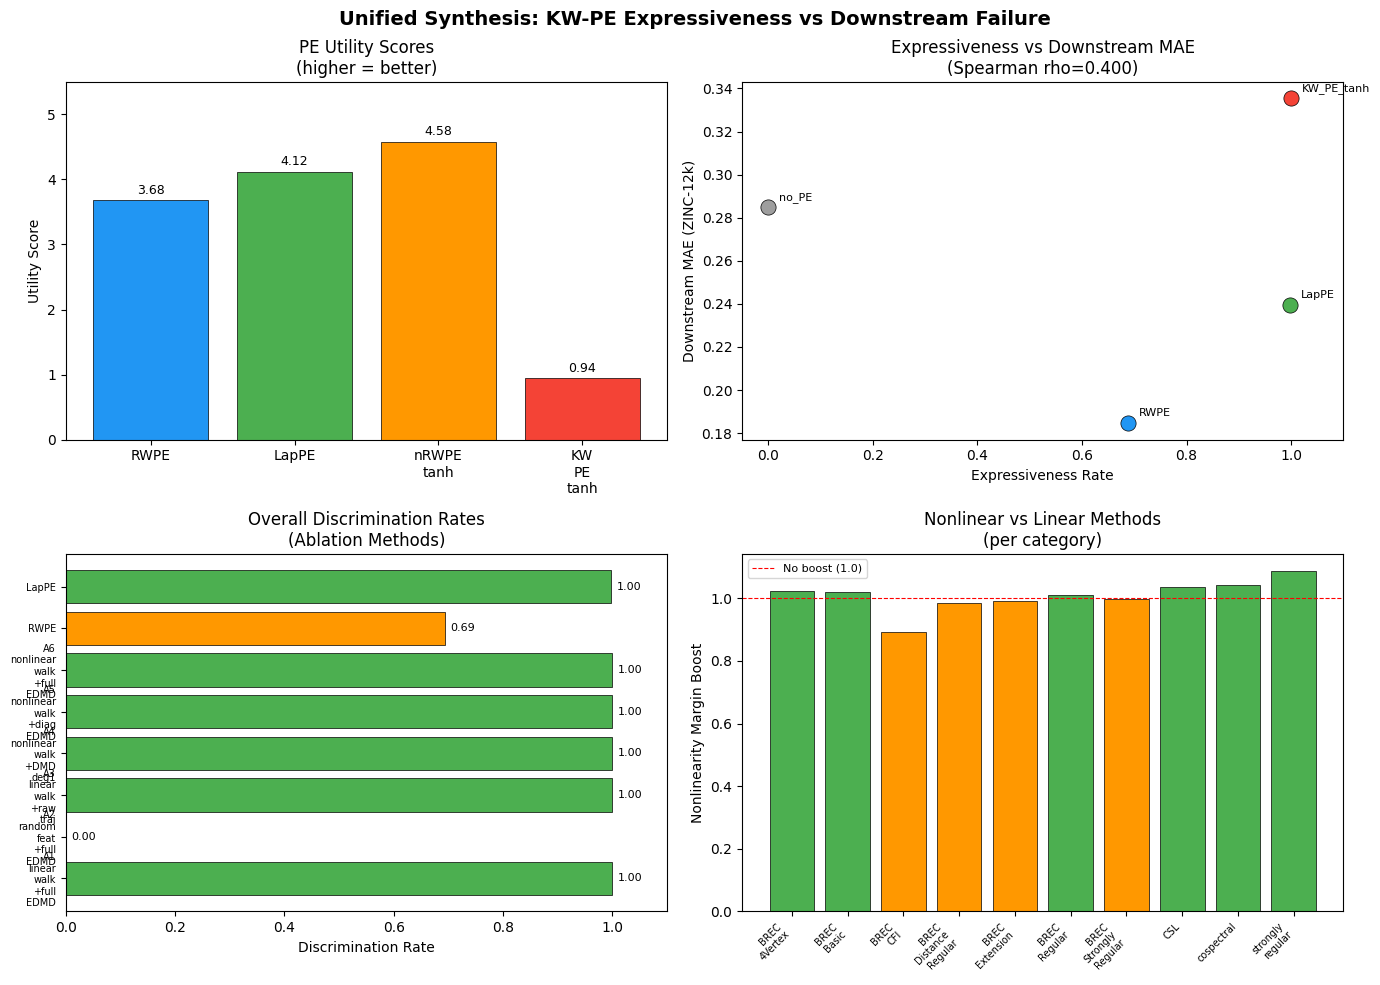

Visualization complete.


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Unified Synthesis: KW-PE Expressiveness vs Downstream Failure", fontsize=14, fontweight='bold')

# --- Plot 1: PE Utility Scores ---
ax = axes[0, 0]
methods_labels = []
utility_vals = []
for m in PE_METHODS:
    info = pe_utility.get(m, {})
    if info:
        methods_labels.append(m.replace("_", "\n"))
        utility_vals.append(info['utility_score'])
colors = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']
bars = ax.bar(methods_labels, utility_vals, color=colors[:len(methods_labels)], edgecolor='black', linewidth=0.5)
ax.set_ylabel("Utility Score")
ax.set_title("PE Utility Scores\n(higher = better)")
for bar, val in zip(bars, utility_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)
ax.set_ylim(0, max(utility_vals) * 1.2)

# --- Plot 2: Expressiveness vs Downstream MAE ---
ax = axes[0, 1]
expr_rates = corr['expressiveness_rates']
maes = corr['downstream_maes']
method_names = corr['methods_used']
scatter_colors = ['#2196F3', '#4CAF50', '#F44336', '#9E9E9E']
for i, (x, y, name) in enumerate(zip(expr_rates, maes, method_names)):
    ax.scatter(x, y, c=scatter_colors[i % len(scatter_colors)], s=120, zorder=5, edgecolors='black', linewidth=0.5)
    ax.annotate(name, (x, y), textcoords="offset points", xytext=(8, 5), fontsize=8)
ax.set_xlabel("Expressiveness Rate")
ax.set_ylabel("Downstream MAE (ZINC-12k)")
ax.set_title(f"Expressiveness vs Downstream MAE\n(Spearman rho={corr['spearman_rho']:.3f})")
ax.set_xlim(-0.05, 1.1)

# --- Plot 3: Discrimination Rates by Method ---
ax = axes[1, 0]
abl_a1 = data['metadata']['analysis_1_ablation_decomposition']
disc_rates = abl_a1.get('overall_discrimination_rates', {})
if disc_rates:
    method_labels_disc = [m.replace("+", "\n+").replace("_", "\n") for m in disc_rates.keys()]
    rates = list(disc_rates.values())
    bar_colors = ['#F44336' if r < 0.01 else '#4CAF50' if r > 0.99 else '#FF9800' for r in rates]
    ax.barh(range(len(rates)), rates, color=bar_colors, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(rates)))
    ax.set_yticklabels(method_labels_disc, fontsize=7)
    ax.set_xlabel("Discrimination Rate")
    ax.set_title("Overall Discrimination Rates\n(Ablation Methods)")
    ax.set_xlim(0, 1.1)
    for i, r in enumerate(rates):
        ax.text(r + 0.01, i, f'{r:.2f}', va='center', fontsize=8)

# --- Plot 4: Nonlinearity Margin Boost per Category ---
ax = axes[1, 1]
cats_sorted = sorted(nonlinearity_margin_boost.keys())
boosts = [nonlinearity_margin_boost[c] for c in cats_sorted]
cat_labels = [c.replace("_", "\n") for c in cats_sorted]
colors_boost = ['#FF9800' if b < 1.0 else '#4CAF50' for b in boosts]
bars = ax.bar(range(len(boosts)), boosts, color=colors_boost, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(boosts)))
ax.set_xticklabels(cat_labels, fontsize=7, rotation=45, ha='right')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=0.8, label='No boost (1.0)')
ax.set_ylabel("Nonlinearity Margin Boost")
ax.set_title("Nonlinear vs Linear Methods\n(per category)")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
print("Visualization complete.")